# Lab 1: 螃蟹年龄预测

## 数据描述

在这个实验中，我们将使用深度学习来预测螃蟹的年龄，数据集 `crab_2000.csv` 包含了 2000 个螃蟹的特征和年龄，我们将使用这些特征来预测螃蟹的年龄。以下是数据集中相关变量的描述：

- Sex: 螃蟹的性别——雄性(Male)、雌性(Female)和不确定(Indeterminate)
- Length: 螃蟹的长度（以英尺为单位）
- Diameter: 螃蟹的直径（以英尺为单位）
- Height: 螃蟹的高度（以英尺为单位）
- Weight: 整个螃蟹的重量（以盎司为单位）
- Shucked Weight: 去壳重量，不含壳的重量（以盎司为单位）
- Viscera Weight: 内脏重量，包裹螃蟹腹部器官的重量（以盎司为单位）
- Shell Weight: 外壳的重量（以盎司为单位）
- Age: 螃蟹的年龄（以月为单位）

## 评估指标

评估指标使用 Mean Absolute Error (MAE) 进行评估，MAE 是预测值与真实值之间差值的绝对值的平均值：

$$
MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
$$

其中 $y_i$ 是真实值，$\hat{y}_i$ 是预测值，$n$ 是样本数量。

## 要求

50 个 epoch 内，在测试集上的 MAE 低于 1.5。


## 数据预处理

我们先读取并观察数据的格式


In [1]:
import pandas as pd

data_frame = pd.read_csv("crab_2000.csv")
data_frame

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,M,1.5500,1.2750,0.4250,33.339012,14.132226,7.881161,8.703297,11
1,I,0.8125,0.5625,0.1875,5.301356,2.338834,1.261553,1.417475,6
2,F,1.7625,1.4000,0.4375,43.275512,19.022514,9.015141,10.560189,11
3,M,1.2625,1.0125,0.3875,24.720764,7.696889,6.775531,8.079607,14
4,F,1.6625,1.3125,0.4500,38.909689,16.811253,7.271647,11.198052,9
...,...,...,...,...,...,...,...,...,...
1995,I,1.0375,0.7875,0.2250,9.525432,3.699610,1.672621,2.693202,7
1996,M,1.5250,1.1875,0.3750,30.277266,11.070480,6.406987,9.213587,14
1997,M,1.3125,1.0000,0.4000,22.977270,8.334753,4.238250,5.102910,10
1998,M,1.5625,1.2000,0.4250,34.586390,16.938826,6.562909,9.213587,11


可以看到，我们的数据集中有 2000 个样本，每个样本有 8 个特征和 1 个标签（Age）。

其中特征有两种类型：

- 一种是类别型，例如 Sex，有三种取值：F、M、I，我们将其转换为 One-hot 编码；
- 一种是数值型，例如 Length、Diameter、Height 等，我们将其归一化，使得均值为 0，方差为 1.


In [2]:
def preprocess_data(df):
    """
    1. 对给定的 DataFrame 进行预处理，提取出 features 和 labels.
    2. 将数值型的 features 进行标准化，将类别型的 features 转换为 one-hot 编码

    Args:
        df (pandas.DataFrame): The input DataFrame containing the data.

    Returns:
        - features (pandas.DataFrame): The preprocessed features.
        - labels (pandas.Series): The labels.
    """
    # 提取特征和标签
    features = df.drop(columns="Age")
    labels = df["Age"]

    # 将数值特征进行标准化
    numeric_features = features.dtypes[features.dtypes != "object"].index
    features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())

    # 将类别特征转换为One-Hot编码
    features = pd.get_dummies(features).astype(float)

    return features, labels


features, labels = preprocess_data(data_frame)
features.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,0.812247,1.059116,0.865772,0.777356,0.706963,0.984957,0.545778,0.0,0.0,1.0
1,-1.733597,-1.925784,-1.769759,-1.410671,-1.362818,-1.339153,-1.458642,0.0,1.0,0.0
2,1.545795,1.582782,1.004484,1.552790,1.565226,1.383091,1.056632,1.0,0.0,0.0
3,-0.180200,-0.040584,0.449636,0.104798,-0.422460,0.596776,0.374193,0.0,0.0,1.0
4,1.200596,1.216216,1.143196,1.212086,1.177142,0.770959,1.232116,1.0,0.0,0.0


可以通过 `features.describe()` 查看数值型特征是否被有效归一化（均值为 0，方差为 1）


In [3]:
features.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
count,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2000.000000,2000.000000,2000.000000
mean,3.215206e-16,-1.101341e-16,3.996803e-16,-2.202682e-16,1.421085e-16,-8.881784e-17,2.238210e-16,0.301000,0.329000,0.370000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.458807,0.469967,0.482925
min,-3.589042e+00,-3.339684e+00,-3.434306e+00,-1.806684e+00,-1.760853e+00,-1.762170e+00,-1.833008e+00,0.000000,0.000000,0.000000
25%,-6.116994e-01,-6.166175e-01,-5.213497e-01,-8.025477e-01,-7.887770e-01,-8.265546e-01,-7.957016e-01,0.000000,0.000000,0.000000
50%,2.512985e-01,2.212492e-01,1.722112e-01,5.446666e-02,-3.935193e-02,-2.530924e-02,6.222122e-02,0.000000,0.000000,0.000000
75%,7.690973e-01,7.449158e-01,7.270599e-01,6.986395e-01,6.901714e-01,7.149718e-01,6.861651e-01,1.000000,1.000000,1.000000
max,2.106744e+00,2.054082e+00,2.669030e+00,3.812719e+00,3.980800e+00,3.941104e+00,4.234846e+00,1.000000,1.000000,1.000000


## 数据集的划分与加载

我们创建一个`CrabDataset`类，继承自`torch.utils.data.Dataset`，这样方面后续处理与加载。

为了保证实验结果的可复现性，我们设置随机数种子 seed=42。


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)


class CrabDataset(Dataset):
    """
    A custom dataset class for handling crab data.

    Args:
        features (pandas.DataFrame): The input features.
        labels (pandas.Series): The corresponding labels.

    Attributes:
        X (torch.Tensor): The input features as a tensor.
        y (torch.Tensor): The corresponding labels as a tensor.
    """

    def __init__(self, features, labels):
        self.X = torch.tensor(features.values, dtype=torch.float)
        self.y = torch.tensor(labels.values, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


crab_data = CrabDataset(features, labels)

我们将数据集划分为训练集和测试集，其中训练集占 80%，测试集占 20%。

Hint：可以通过 `torch.utils.data.random_split` 快速实现。


In [5]:
from torch.utils.data import random_split


def split_data(dataset, train_ratio=0.8):
    """
    Splits the given dataset into training and testing datasets based on the specified train ratio.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to be split.
        train_ratio (float, optional): The ratio of the dataset to be used for training. Defaults to 0.8.

    Returns:
        torch.utils.data.Dataset: The training dataset.
        torch.utils.data.Dataset: The testing dataset.
    """
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset


train_dataset, test_dataset = split_data(crab_data)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1600
Test dataset size: 400


然后可以用`torch.utils.data.DataLoader`来加载数据集。


In [6]:
train_iter = DataLoader(train_dataset, batch_size=64, shuffle=True)
X_batch, y_batch = next(iter(train_iter))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

X_batch shape: torch.Size([64, 10])
y_batch shape: torch.Size([64])


## 构建 MLP 网络

我们创建一个多层感知机（MLP）网络，包含一个输入层、任意个隐藏层和一个输出层。其中，输入层的维度为 10，即数据集中的特征数；输出层的维度为 1，即预测的年龄。隐藏层的维度可以自行设置。


In [7]:
import torch.nn as nn
import torch.nn.functional as F


class CrabNet(nn.Module):
    def __init__(self):
        super(CrabNet, self).__init__()
        self.input = nn.Linear(10, 128)
        self.output = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.output(x)
        return x


net = CrabNet()
x_test = torch.randn(20, 10)
y_test = net(x_test)
assert y_test.shape == torch.Size([20, 1]), f"Expected output shape: [20, 1], but got: {y_test.shape}"

## 训练与测试

我们将训练一个 epoch 的代码封装在`train_epoch`函数中，其中流程如下：

1. 遍历训练集，将数据输入模型，得到预测值；
2. 计算预测值与真实值之间的差值，然后计算损失；
3. 通过反向传播更新模型参数。
4. 返回训练集上的平均损失。

然后我们实现了一个`eval_model`函数来评估模型的性能：

- 当传入的参数`loss_fn`为`nn.MSELoss()`时，可以得到模型在测试集上的 MSE；
- 当传入的参数`loss_fn`为`nn.L1Loss()`时，可以得到模型的 MAE 评估指标。


In [8]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def train_epoch(net, device, train_iter, loss_fn, optimizer):
    """
    将 net 模型在 train_iter 上训练一个 epoch, 并返回训练损失.

    Args:
        net (torch.nn.Module): The neural network model.
        device (torch.device): The device to run the training on (e.g., 'cpu', 'cuda').
        train_iter (torch.utils.data.DataLoader): The training data iterator.
        loss_fn (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.

    Returns:
        train_loss (float): The training loss.
    """
    # 将模型设置为训练模式
    net.train()
    metrics = Accumulator(2)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat.view(-1), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        metrics.add(loss * len(y), len(y))
    train_loss = metrics[0] / metrics[1]
    return train_loss


@torch.no_grad()
def eval_model(net, device, data_iter, loss_fn):
    """
    评估 net 模型在 data_iter 上的性能，并返回评估损失.

    Parameters:
    - net (torch.nn.Module): The neural network model to evaluate.
    - device (torch.device): The device to run the evaluation on (e.g., 'cpu', 'cuda').
    - data_iter (torch.utils.data.DataLoader): The data iterator.
    - loss_fn (torch.nn.Module): The loss function used to evaluate the model.

    Returns:
    - eval_loss (float): The evaluation loss.
    """
    # 将模型设置为评估模式
    net.eval()
    metrics = Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        loss = loss_fn(y_hat.view(-1), y.view(-1))
        metrics.add(loss * len(y), len(y))
    eval_loss = metrics[0] / metrics[1]
    return eval_loss

In [9]:
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrabNet()
model = model.to(device)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_iter = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=512, shuffle=False)

train_ls, test_ls = [], []
for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, device, train_iter, loss_fn, optimizer)
    test_loss = eval_model(model, device, test_iter, loss_fn)
    print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f}")
    train_ls.append(train_loss)
    test_ls.append(test_loss)

Epoch 1/50 - Train Loss: 82.657420 - Test Loss: 58.991157
Epoch 2/50 - Train Loss: 43.374937 - Test Loss: 27.497917
Epoch 3/50 - Train Loss: 22.967960 - Test Loss: 19.187202
Epoch 4/50 - Train Loss: 16.409851 - Test Loss: 13.015024
Epoch 5/50 - Train Loss: 10.816114 - Test Loss: 8.000975
Epoch 6/50 - Train Loss: 7.007162 - Test Loss: 5.541493
Epoch 7/50 - Train Loss: 5.365051 - Test Loss: 4.757820
Epoch 8/50 - Train Loss: 4.814942 - Test Loss: 4.558245
Epoch 9/50 - Train Loss: 4.630365 - Test Loss: 4.497282
Epoch 10/50 - Train Loss: 4.501982 - Test Loss: 4.464755
Epoch 11/50 - Train Loss: 4.414511 - Test Loss: 4.411383
Epoch 12/50 - Train Loss: 4.334674 - Test Loss: 4.360497
Epoch 13/50 - Train Loss: 4.283114 - Test Loss: 4.352846
Epoch 14/50 - Train Loss: 4.241878 - Test Loss: 4.288565
Epoch 15/50 - Train Loss: 4.185252 - Test Loss: 4.257241
Epoch 16/50 - Train Loss: 4.143606 - Test Loss: 4.252192
Epoch 17/50 - Train Loss: 4.118437 - Test Loss: 4.212588
Epoch 18/50 - Train Loss: 4.090

画出模型在训练集和测试集上的 Loss 下降情况。

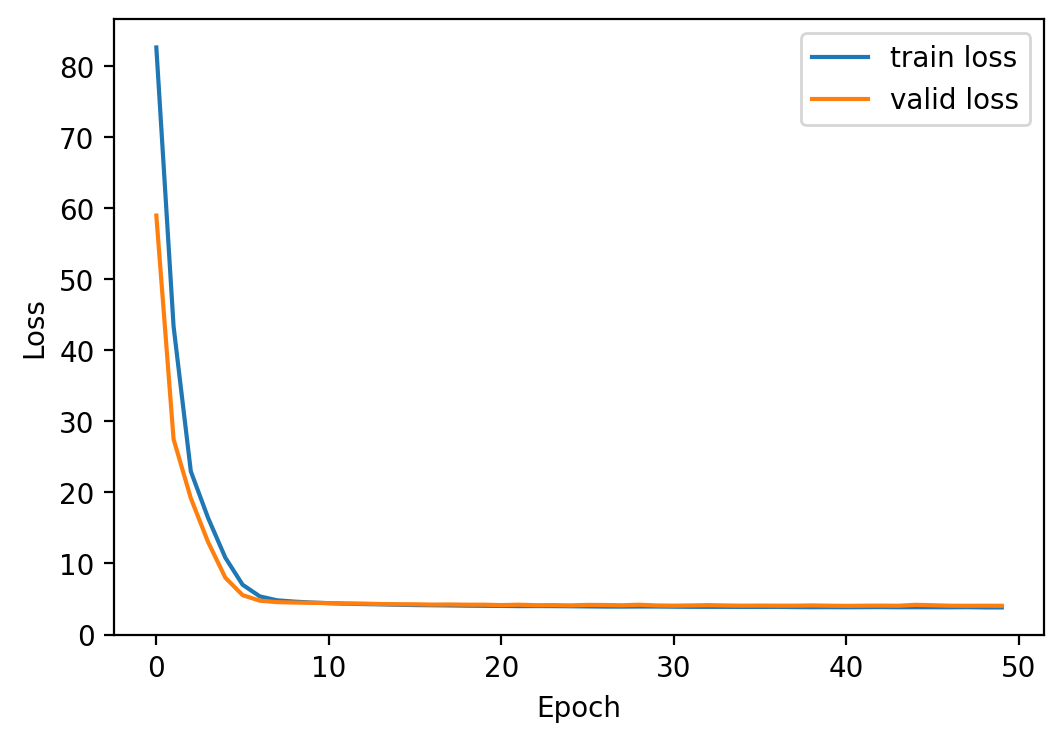

In [10]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.figure(figsize=(6, 4))
plt.plot(train_ls, label="train loss")
plt.plot(test_ls, label="valid loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 模型评估

评估模型在测试集上的 MAE

In [11]:
mae = eval_model(model, device, test_iter, nn.L1Loss())
print(f"Mean Absolute Error: {mae:.6f}")

Mean Absolute Error: 1.349196
